In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycountry
import seaborn as sns
import swifter

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud

## 1. Analyze the given data and understand the problem

#### 1.1 Identify what attributes are available for both users and questions and their data types
#### 1.2 Check for missing values
#### 1.3 Check if train questions have only the right answer or if they also contain the uids for those who responded to a specific question
#### 1.4 Check if there are users wich had more than 1 "winner" answer
#### 1.5 Train v.s Test distribution

In [2]:
df_users = pd.read_csv('users.csv')
print(df_users.info())
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4842850 entries, 0 to 4842849
Data columns (total 13 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Unnamed: 0         int64 
 1   id                 int64 
 2   display_name       object
 3   about_me           object
 4   creation_date      object
 5   last_access_date   object
 6   location           object
 7   reputation         int64 
 8   up_votes           int64 
 9   down_votes         int64 
 10  views              int64 
 11  website_url        object
 12  profile_image_url  object
dtypes: int64(6), object(7)
memory usage: 480.3+ MB
None


,Unnamed: 0,id,display_name,about_me,creation_date,last_access_date,location,reputation,up_votes,down_votes,views,website_url,profile_image_url
0,0,568,David McGraw,"<p>Grinding my way to the moon. Startups, prod...",2008-08-06 19:50:58.627 UTC,2020-10-29 18:57:14.293 UTC,"Wichita, KS, United States",5019,207,37,614,https://www.moonlitsolutions.com,NaN
1,1,1483,Grzegorz Gierlik,"<p>Software developer, former team leader. \nF...",2008-08-15 20:40:17.893 UTC,2020-12-03 12:38:44.23 UTC,"Szczecin, Poland",10402,1277,4,1336,http://ggierlik.wordpress.com,NaN
2,2,1544,jeffm,"<p>C++, C#, Windows programmer</p>",2008-08-16 14:15:09.933 UTC,2020-12-01 19:42:49.983 UTC,United States,2950,798,42,337,http://www.pearlsoftware.com,NaN
3,3,2440,Sire,NaN,2008-08-22 10:47:46.27 UTC,2020-12-03 18:54:37.033 UTC,Sweden,3511,964,34,358,NaN,https://i.stack.imgur.com/aav7m.png?s=128&g=1
4,4,3054,John Spurlock,NaN,2008-08-26 13:48:36.693 UTC,2020-12-05 22:56:09.93 UTC,NaN,1713,2,0,283,https://johnspurlock.com,NaN


In [3]:
df_questions = pd.read_csv('questions_train.csv')
print(df_questions.info())
df_questions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482735 entries, 0 to 482734
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          482735 non-null  int64  
 1   Unnamed: 0.1        482735 non-null  int64  
 2   question_id         482735 non-null  int64  
 3   owner_user_id       475970 non-null  float64
 4   title               482735 non-null  object 
 5   text                482735 non-null  object 
 6   date                482735 non-null  object 
 7   accepted_answer_id  482735 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 29.5+ MB
None


,Unnamed: 0,Unnamed: 0.1,question_id,owner_user_id,title,text,date,accepted_answer_id
0,0,1,61059891,12481897.0,folium.Marker does not does decode properly,<p>I have a folium map called imap.\nI have cr...,2020-04-06T12:29:30.87,61060428
1,1,2,61199055,13296781.0,Using QStackedWidget in PyQt5,<p>I have QStackedWidget in ApplicationWindow ...,2020-04-14T00:47:21.127,61200491
2,2,3,61246717,12320080.0,Hadoop connection refused on port 9000. Virtua...,<p>I installed Hadoop on VirtualBox Ubuntu. Al...,2020-04-16T09:17:00.277,61255991
3,3,4,61095077,7902677.0,pyscreenshot get remote windows server's scree...,<p>The python2 script was executed by the syst...,2020-04-08T07:07:34.197,61115533
4,4,5,61179159,13297108.0,Can't construct a java object for tag:yaml.org...,<p>I'm trying to read yaml file contents using...,2020-04-12T22:41:11.913,61179673


In [4]:
df_questions_tst = pd.read_csv('questions_test.csv')
print(df_questions_tst.info())
df_questions_tst.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120742 entries, 0 to 120741
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          120742 non-null  int64  
 1   question_id         120742 non-null  int64  
 2   owner_user_id       119092 non-null  float64
 3   title               120742 non-null  object 
 4   text                120742 non-null  object 
 5   date                120742 non-null  object 
 6   accepted_answer_id  120742 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 6.4+ MB
None


,Unnamed: 0,question_id,owner_user_id,title,text,date,accepted_answer_id
0,0,60382284,6279751.0,Show/Hide Bokeh widgets based on another widget,"<p>I have a checkbox A that has two options, a...",2020-02-24T18:54:16.74,0
1,1,60471556,10045053.0,Why is composition of identity and unary funct...,"<p><a href=""https://mostly-adequate.gitbooks.i...",2020-03-01T02:45:29.663,0
2,2,60472988,11816815.0,How to create a shortcut key for a JLabel?,"<p><a href=""https://i.stack.imgur.com/74SmA.jp...",2020-03-01T07:39:21.583,0
3,3,60481026,12990519.0,text-align: center is not working properly?,<p>I used javascript to change the divs but af...,2020-03-02T00:13:59.287,0
4,4,60486309,11157436.0,Set flag to check if parameters are filled in ...,<p>I want to have a flag that checks if parame...,2020-03-02T09:54:59.683,0


In [5]:
def show_missing_fields(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
    print(missing_value_df)

In [6]:
show_missing_fields(df_users)

                         column_name  percent_missing
Unnamed: 0                Unnamed: 0         0.000000
id                                id         0.000000
display_name            display_name         0.002622
about_me                    about_me        84.644992
creation_date          creation_date         0.000000
last_access_date    last_access_date         0.000000
location                    location        65.408778
reputation                reputation         0.000000
up_votes                    up_votes         0.000000
down_votes                down_votes         0.000000
views                          views         0.000000
website_url              website_url        88.891004
profile_image_url  profile_image_url        10.238785


In [7]:
show_missing_fields(df_questions)

                           column_name  percent_missing
Unnamed: 0                  Unnamed: 0          0.00000
Unnamed: 0.1              Unnamed: 0.1          0.00000
question_id                question_id          0.00000
owner_user_id            owner_user_id          1.40139
title                            title          0.00000
text                              text          0.00000
date                              date          0.00000
accepted_answer_id  accepted_answer_id          0.00000


In [8]:
show_missing_fields(df_questions_tst)

                           column_name  percent_missing
Unnamed: 0                  Unnamed: 0          0.00000
question_id                question_id          0.00000
owner_user_id            owner_user_id          1.36655
title                            title          0.00000
text                              text          0.00000
date                              date          0.00000
accepted_answer_id  accepted_answer_id          0.00000


#### Change date columns from string to date data type
    Because date formats are inconsistent (some have miliseconds, some do not, I will use only %Y%m%d format

In [9]:
def format_date(datetime_date):
    try:
        # Split for users dates
        date_format, _, _ = datetime_date.split(' ')
    except:
        # Split for questions dates
        date_format, _ = datetime_date.split('T')
        
    return date_format

### Use swifter to optimize the processing speed of apply function

In [10]:
df_users.creation_date = df_users.creation_date.swifter.apply(format_date)
df_users.last_access_date = df_users.last_access_date.swifter.apply(format_date)

df_questions.date = df_questions.date.swifter.apply(format_date)

df_questions_tst.date = df_questions_tst.date.swifter.apply(format_date)


Pandas Apply:   0%|          | 0/4842850 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4842850 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/482735 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/120742 [00:00<?, ?it/s]

In [11]:
df_users.last_access_date = pd.to_datetime(df_users.last_access_date, format='%Y-%m-%d')
df_users.creation_date = pd.to_datetime(df_users.creation_date, format='%Y-%m-%d')

df_questions.date = pd.to_datetime(df_questions.date, format='%Y-%m-%d')

df_questions_tst.date = pd.to_datetime(df_questions_tst.date, format='%Y-%m-%d')



In [12]:
print('The oldest user creation date is: {}'.format(df_users.creation_date.min()))
print('The most recent user creation date is: {}\n'.format(df_users.creation_date.max()))

print('The oldest question date is: {}'.format(df_questions.date.min()))
print('The most recent question date is: {}\n'.format(df_questions.date.max()))

print('The oldest question date for TEST SET is: {}'.format(df_questions_tst.date.min()))
print('The most recent question date for TEST SET is: {}'.format(df_questions_tst.date.max()))

The oldest user creation date is: 2008-07-31 00:00:00
The most recent user creation date is: 2020-12-06 00:00:00

The oldest question date is: 2020-01-01 00:00:00
The most recent question date is: 2020-12-06 00:00:00

The oldest question date for TEST SET is: 2020-01-01 00:00:00
The most recent question date for TEST SET is: 2020-12-06 00:00:00


#### When I will recommend the top 20 users for a question, I must take into account to not recommend users which did not had an existing account when the question was asked.

In [13]:
total_questions = len(df_questions)
total_unique_questions = len(df_questions.question_id)
unique_user_answers = len(df_questions.accepted_answer_id)
ownwer_answers_own_question = len(df_questions[df_questions.owner_user_id == df_questions.accepted_answer_id])

print('Number of questions is: {}'.format(total_questions))
print('Number of unqiue accepted answer ids is: {}'.format(unique_user_answers))
print('Number of unique questions is {}'.format(total_unique_questions))
print('Numbers of questions where the owner answered to his own question is : {}'.format(ownwer_answers_own_question))

Number of questions is: 482735
Number of unqiue accepted answer ids is: 482735
Number of unique questions is 482735
Numbers of questions where the owner answered to his own question is : 0


### Check if count of words distribution is the same for both train and test 

In [14]:
train_qs = df_questions.text
test_qs = df_questions_tst.text

# Use a naive word tokenizer, using only space char to create tokens for speed and simplicity
word_train = train_qs.apply(lambda x: len(x.split(' ')))
word_test = test_qs.apply(lambda x: len(x.split(' ')))

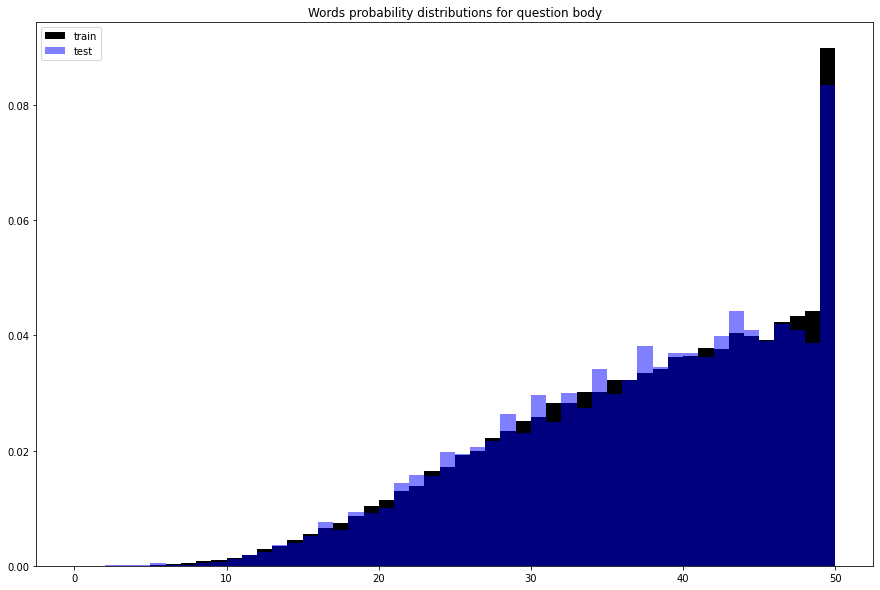

In [15]:
plt.figure(figsize=(15, 10))
plt.hist(word_train, bins=50, range=[0, 50], color='black', density=True, label='train')
plt.hist(word_test, bins=50, range=[0, 50], color='blue',alpha=0.5, density=True, label='test')
plt.title('Words probability distributions for question body')
plt.legend()
plt.show()

In [16]:
train_titles = df_questions.title
test_titles = df_questions_tst.title

# Use a naive word tokenizer, using only space char to create tokens for speed and simplicity
title_words_train = train_titles.apply(lambda x: len(x.split(' ')))
title_words_test = test_titles.apply(lambda x: len(x.split(' ')))

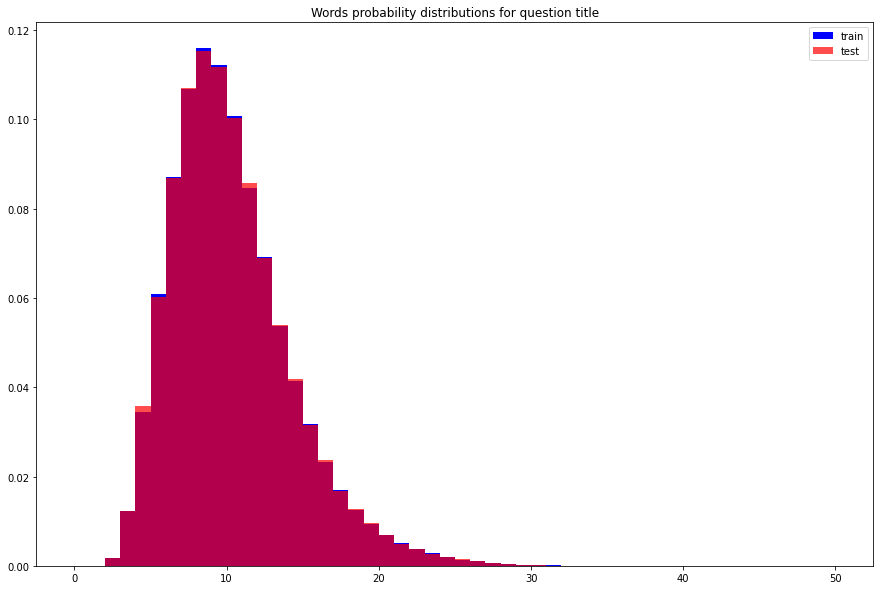

In [17]:
plt.figure(figsize=(15, 10))
plt.hist(title_words_train, bins=50, range=[0, 50], color='blue', density=True, label='train')
plt.hist(title_words_test, bins=50, range=[0, 50], color='red',alpha=0.7, density=True, label='test')
plt.legend()
plt.title('Words probability distributions for question title')
plt.show()

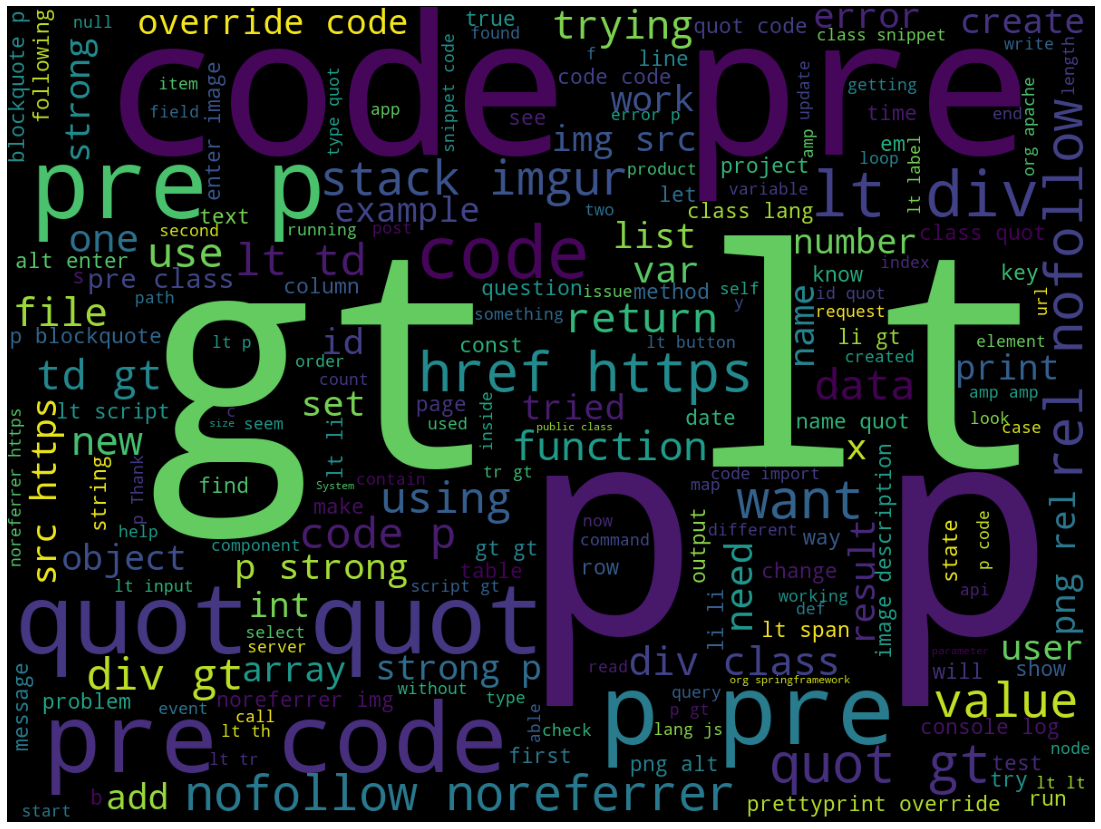

In [18]:
cloud = WordCloud(width = 1200, height= 900).generate(" ".join(df_questions.text.sample(10000)))

plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

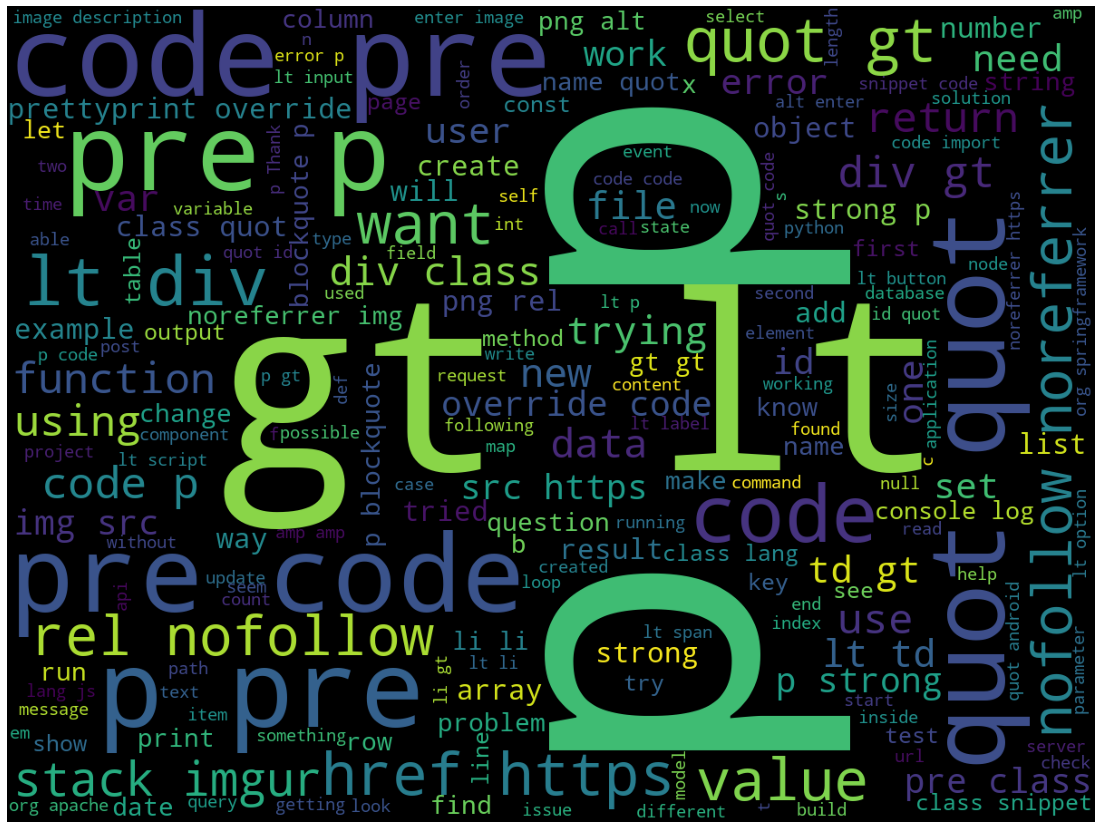

In [19]:
cloud_tst = WordCloud(width = 1200, height= 900).generate(" ".join(df_questions_tst.text.sample(10000)))

plt.figure(figsize=(20, 15))
plt.imshow(cloud_tst)
plt.axis('off')
plt.show()

In [68]:
common_accepted_uid = res = df_users.merge(df_questions, left_on='id', right_on='accepted_answer_id', how='inner')
common_owner_uid = res = df_users.merge(df_questions, left_on='id', right_on='owner_user_id', how='inner')

In [70]:
print('No. of common accepted users ids is: ', len(common_accepted_uid))
print('No. of common accepted owner users ids is: ', len(common_owner_uid))

No. of common accepted users ids is:  0
No. of common accepted owner users ids is:  475970


### Conclusion

#### For each question we only know what is the accepted answer, but we have no data regarding to other possible answers that were given to a specific question.

#### Given this information, it is pretty obvious that a Colaborative Filtering approach will not be suitable for this task.

## 2. Exploratory Data Analysis

#### 2.1 Compute the time spent on platform for each user
#### 2.2 Check distribution for numerical data
#### 3.3 Plot numerical data against  time

In [20]:
df_users['time_spent_days'] = (df_users['last_access_date'] - df_users['creation_date']).dt.days

In [21]:
df_users.head()

,Unnamed: 0,id,display_name,about_me,creation_date,last_access_date,location,reputation,up_votes,down_votes,views,website_url,profile_image_url,time_spent_days
0,0,568,David McGraw,"<p>Grinding my way to the moon. Startups, prod...",2008-08-06,2020-10-29,"Wichita, KS, United States",5019,207,37,614,https://www.moonlitsolutions.com,NaN,4467
1,1,1483,Grzegorz Gierlik,"<p>Software developer, former team leader. \nF...",2008-08-15,2020-12-03,"Szczecin, Poland",10402,1277,4,1336,http://ggierlik.wordpress.com,NaN,4493
2,2,1544,jeffm,"<p>C++, C#, Windows programmer</p>",2008-08-16,2020-12-01,United States,2950,798,42,337,http://www.pearlsoftware.com,NaN,4490
3,3,2440,Sire,NaN,2008-08-22,2020-12-03,Sweden,3511,964,34,358,NaN,https://i.stack.imgur.com/aav7m.png?s=128&g=1,4486
4,4,3054,John Spurlock,NaN,2008-08-26,2020-12-05,NaN,1713,2,0,283,https://johnspurlock.com,NaN,4484


In [22]:
def plot_distribution(field):
    plot = plt.plot()
    plt.hist(df_users[field], bins=30, log=True)
    plt.ylabel('Count')
    plt.xlabel(field)
    plt.show()

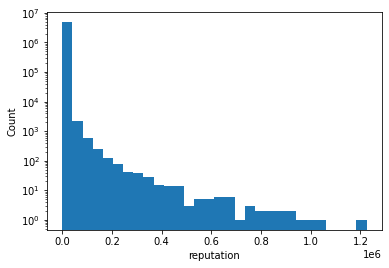

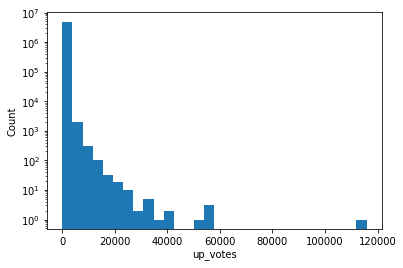

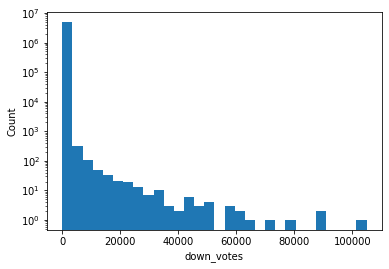

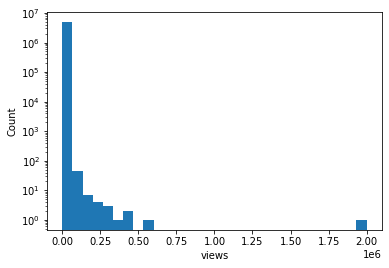

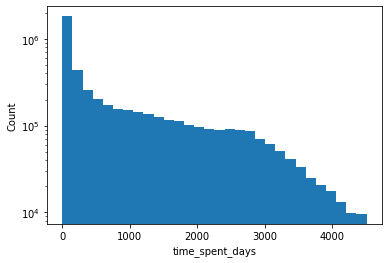

In [23]:
numeric_fields = ['reputation', 'up_votes', 'down_votes', 'views', 'time_spent_days']

for field in numeric_fields:
    plot_distribution(field)

#### For ploting the relationship between numerical data and time I will use only a sample of data in order to be efficient in terms of speed
#### I will also remove the users which have reputation, up-votes etc. less than 1 

In [24]:
def plot_joint_time(field):
    df_plot = df_users[df_users[field] > 1]
    sample_data = df_plot.sample(5000)
    sns.jointplot(data=sample_data, x='time_spent_days', y=field, kind="scatter")
    plt.show()

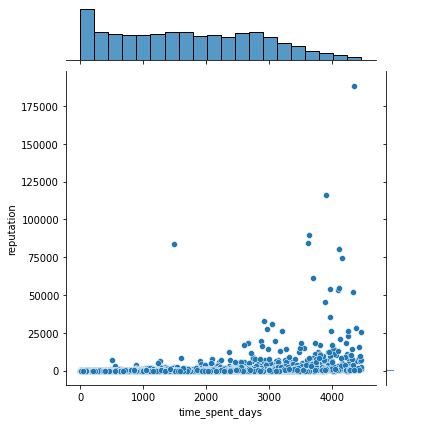

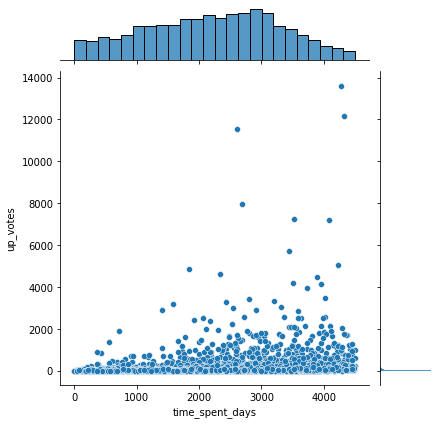

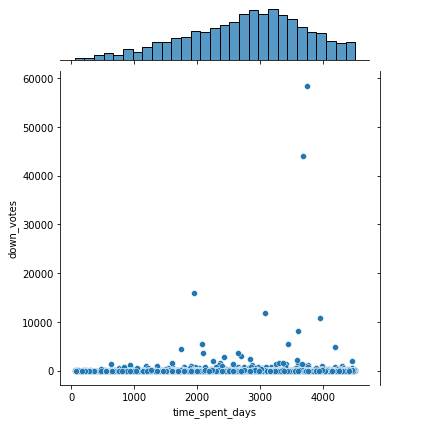

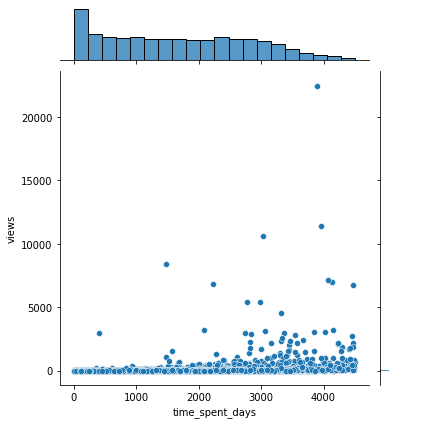

In [25]:
for field in numeric_fields:
    if field == 'time_spent_days':
        continue
    plot_joint_time(field)

#### We can see that for each numerical attribute is a tendency to have higher values as the numbers of days grow
#### Due to that, in the data processing phase, I will normalize these values based on time spent on the platform by each user. (A user with 100 reputation after 5 days might be just as good (or better) than a user with 500 reputation after 2 years)

## 3. Data Processing and Encoding
#### 3.1 Fill NaN values
#### 3.2 Encode categorical columns into numericals
#### 3.3 Scale numerical values
#### 3.4 Process text data and encode it

In [26]:
# For features like  about_me or website url is impossible to impute missing values
# For location, it is possible to impute missing values with a KNN classifier
# But for now, I will just replace missing values  with empty string 

df_users.fillna(value='', inplace=True)

In [27]:
# location seems to have a lot of edge cases regarding the string formating and country name (ex: USA and United States)
# I will use the pycountry library, but there will still edge cases like Türkiye, Deutschland, Italia, etc
# I will let them as they are for now

def extract_country(location):
    special_cases = ['UK']
    for country in pycountry.countries:
        if country.name in location or country.alpha_2 in location:
            return country.alpha_2
    
    for special_case in special_cases:
        if special_case in location:
            return special_case

    return 'unknown'

In [28]:
# df_users.location = df_users.location.swifter.apply(extract_country)

In [29]:
len(df_users[df_users.location == 'unknown'])

14

In [30]:
def create_binary_encoding(value):
    if value:
        return 1
    return 0

In [31]:
transform_binary_features = ['website_url', 'profile_image_url', 'about_me']

for feature in transform_binary_features:
    df_users[feature] = df_users[feature].swifter.apply(create_binary_encoding)

Pandas Apply:   0%|          | 0/4842850 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4842850 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4842850 [00:00<?, ?it/s]

In [32]:
df_users.head()

,Unnamed: 0,id,display_name,about_me,creation_date,last_access_date,location,reputation,up_votes,down_votes,views,website_url,profile_image_url,time_spent_days
0,0,568,David McGraw,1,2008-08-06,2020-10-29,"Wichita, KS, United States",5019,207,37,614,1,0,4467
1,1,1483,Grzegorz Gierlik,1,2008-08-15,2020-12-03,"Szczecin, Poland",10402,1277,4,1336,1,0,4493
2,2,1544,jeffm,1,2008-08-16,2020-12-01,United States,2950,798,42,337,1,0,4490
3,3,2440,Sire,0,2008-08-22,2020-12-03,Sweden,3511,964,34,358,0,1,4486
4,4,3054,John Spurlock,0,2008-08-26,2020-12-05,,1713,2,0,283,1,0,4484


### Scale attributes based on how old their account is

In [33]:
alpha = 1
df_users.time_spent_days += alpha # Avoid division to zero
for field in numeric_fields:
    if field == 'time_spent_days':
        continue
    df_users[field] = df_users[field] / df_users.time_spent_days




In [34]:
df_users.reputation.max()

1748.0

#### Scale numeric features to  have an average of 0 and unit variance 

In [35]:
used_features = [
    'about_me',
    'reputation',
    'up_votes',
    'down_votes',
    'views',
    'website_url',
    'profile_image_url',
    'time_spent_days'
]

X_users = df_users[used_features].values
scaler = StandardScaler()

X_users_scaled = scaler.fit_transform(X_users)

In [36]:
numeric_fields
for item in numeric_fields:
    print(item)
    print(df_users[item].max())

reputation
1748.0
up_votes
39.0
down_votes
38.745318352059925
views
2961.0
time_spent_days
4511


### Clean text

#### For removing html tags from questions body I will use BeautifulSoup. With this approach I am not handling the edge case where the question might be related to  HTML and contain code samples, but for now I will proceed further.

#### I will not remove any other chars like grammar because I might do more harm than good for tokens like:  C++, C# 
#### Also, I will not apply any lemmatization/stemming for the moment as I am not expecting to provide to much improvement

In [37]:
def remove_html_tags(text):
    clear_text = BeautifulSoup(text).text
    return clear_text

df_questions.title = df_questions.title.swifter.apply(remove_html_tags)
df_questions.text = df_questions.text.swifter.apply(remove_html_tags)


Pandas Apply:   0%|          | 0/482735 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/482735 [00:00<?, ?it/s]

### Text encoding

#### Here I have to choose between word embedings and TfIdf.
#### I am expecting that a pre-trained model for word embedings like word2vec, Glove or BERT will not perform that good for text which is related to tech and computer science. 
#### Because training my own model for word embedings would take some time and because I want to build a simple working solution in the first iteration, I will go for TFIDF encoding.

In [38]:
df_questions_train, df_questions_validation = train_test_split(df_questions, test_size=0.2, random_state=43)

In [39]:
title_train = df_questions_train.title.tolist()
body_train = df_questions_train.text.tolist()

title_validation = df_questions_validation.title.tolist()
body_validation = df_questions_validation.text.tolist()

In [87]:
# tfidf_title = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,3), max_df= 0.6, min_df=0.005)
# tfidf_body = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,3), max_df= 0.6, min_df=0.005)
tfidf_title = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,3), max_df= 0.6, min_df=0.005)
tfidf_body = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,2), max_features = 300)
# Train Tfidf transformers & encode train data
title_train_vec = tfidf_title.fit(title_train)
body_train_vec = tfidf_body.fit(body_train)


In [88]:
X_title = tfidf_title.transform(title_train)
X_body = tfidf_body.transform(body_train)

In [89]:
# Encode validation data
X_title_val = tfidf_title.transform(title_validation)
X_body_val = tfidf_body.transform(body_validation)

In [ ]:
tfidf_body.vocabulary_

In [ ]:
len(tfidf_body.vocabulary_)

In [ ]:
trans = tfidf_body.transform(body_train[0:200000])


## 4.Model

#### The main idea here is to use similarities. 

#### For questions, we can use cosine similarity between TFIDF vectors for question's title and body and the total similarity could be the sum between them or any other heuristic (later we can give higher weight for title or for body similarity if we find that one of them is more relevant)

#### Based on these question similarities, for each new question we can obtain the most similar 20 questions from training set and predict their accepted_answer_id.

#### Besides that, another approach would be that for each question, we get the most similar question from training, and based on owner_id, we get the most similar 20 users based on Euclidean or Manhattan distance.


#### Finally, a hybrid approach will consist in taking the most similar questions that have similarity higher then a specified treshold and predict theri a ccepted_answer_id and for the rest  of predictions (up until 20), to get the most similar users with the question's  owner.

In [ ]:
y_dummy = np.ones(X_users.shape[0])

knn_users = KNeighborsClassifier(n_jobs=-1)
knn_users.fit(X_users, y_dummy)

#### I suppose that the users must be recommended a few moments after a question was asked
#### For making sure that this contraint is met, I will filter the users which did not have an account when the question was asked

In [55]:
def get_user_validity(uid, question_date):
    print(uid)
    user = df_users[df_users.id == uid]
    print(user.creation_date, type(user.creation_date))
    print(question_date, type(question_date))
    if user.creation_date <= question_date:
        return True
    return False

In [94]:
def get_most_nsimilar(body, title, n=20):
    question_data = {}
    
    for index in range(X_title.shape[0]):
        qid = df_questions_train.question_id.values[index]
        q_date = df_questions_train.date.values[index]
        accepted_answ_uid = df_questions_train.accepted_answer_id.values[index]
        
#         is_valid = get_user_validity(accepted_answ_uid, q_date)
#         if not is_valid:
#             continue
            
        sim_title = cosine_similarity(X_title[index, :], title)
        sim_body = cosine_similarity(X_body[index, :], body)
        total_sim = sim_title + sim_body
        
        # Skip item when sim for question is computed with itself
        if total_sim == 2:
            continue

        question_data[accepted_answ_uid] = total_sim
        
    sorted_uids = sorted(question_data.items(), key=lambda x: x[1], reverse=True)
    top_n = sorted_uids[:n]
    return top_n

In [ ]:
body = X_body_val[0, :]
title = X_title_val[0,:]

res = get_most_nsimilar(body, title)

#### That is how the output for a new question would like like (user id from top 20 most similar questions ordered and their actual similarity  score)

In [96]:
res

[(64358661, array([[1.72610311]])),
 (65162333, array([[1.59298755]])),
 (61111513, array([[1.56377187]])),
 (61455286, array([[1.4244001]])),
 (64531187, array([[1.42356556]])),
 (64487794, array([[1.40329231]])),
 (61458957, array([[1.36663152]])),
 (62712794, array([[1.36297515]])),
 (64141094, array([[1.35562264]])),
 (61667655, array([[1.34090309]])),
 (60001045, array([[1.33096897]])),
 (60565350, array([[1.31325537]])),
 (64206299, array([[1.31038291]])),
 (63274836, array([[1.29729527]])),
 (59653895, array([[1.2964545]])),
 (63857397, array([[1.28806224]])),
 (64973121, array([[1.28322371]])),
 (60176324, array([[1.2832186]])),
 (63897066, array([[1.2821149]])),
 (59890510, array([[1.28204298]]))]